# Synthetic Seismogram Generation with Aki-Richards Formulation

This notebook implements synthetic seismogram generation based on Aki and Richards' formulation for a point source in a homogeneous whole space. The implementation is completed with vibe coding, and addresses the criteria of Assignment 1:
- Part A - Theoretical Displacement Seismogram
    - Implement Brune-type m'(t)
    - Implement dip/strike/rake mechanics
    - Synthesize displacement (for near, intermediate, and far-field terms) and plot 3-component seismograms
- Part B and Part C - See derivations on the final report
- Part D - Source at Depth with General Moment Tensor
    - Place the source at depth and arbitrary horizontal position
    - Use pure double couple and general full tensor
    - Use several f_c values to probe bandwidth/resolution
- Part E - Surface Arrays
    - Implement rectangular grids of stations
    - Inlcude apertures and interstation spacings
    - Simulate displacement and compute strain
- Part F - Array-Derived Strain
    - Estimate spatial gradients with centered differences
    - Form the final symmetric strain estimate
- Part G - See one page on the final report

In [28]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import griddata
import pandas as pd
import config_setup

In [ ]:
# Load a .json file with our config information
config = config_setup.load_config("../config.json")

# Extract key parameters from configuration
source_params = config["source_parameters"]
sim_params = config["simulation_parameters"]
elastic_params = config["elastic_constants"]
geom_config = config["array_geometry"]

# Source parameters
M0 = source_params["M0"]
fc = source_params["default_fc"]
zs = source_params["zs"]

# Earth model parameters
rho = elastic_params["rho"]
alpha = elastic_params["alpha"]
beta = elastic_params["beta"]

# Simulation parameters
dt = sim_params["dt"]
duration = sim_params["duration"]
taper_length = sim_params["taper_length"]

✓ Configuration loaded from: ../config.json


In [30]:
#source(): time-domain m'(t) and analytic d2m/dt2; mechanism builders (strike/dip/rake → M_hat
# Uses Brune moment implementation
def source(t, M0, fc, derivative=0):
    """
    Time-domain Brune moment rate function and its derivatives.
    
    Parameters:
    -----------
    t : array
        Time values in seconds
    M0 : float
        Seismic moment in N⋅m
    fc : float
        Corner frequency in Hz
    derivative : int
        0 for m'(t), 2 for d²m'/dt²
        
    Returns:
    --------
    array
        Moment rate function or its second derivative
    """
    # Ensure causality (t < 0 gives zero)
    t_pos = np.maximum(t, 0)
    
    # Brune moment rate: m'(t) = M0 * (2πfc)² * t * exp(-2πfc * t)
    omega_c = 2 * np.pi * fc
    
    if derivative == 0:
        # First derivative of moment (moment rate)
        result = M0 * omega_c**2 * t_pos * np.exp(-omega_c * t_pos)
    elif derivative == 2:
        # Second derivative of moment rate (analytic)
        # d²m'/dt² = M0 * (2πfc)² * exp(-2πfc*t) * (2πfc)² * (1 - 2πfc*t)
        result = M0 * omega_c**4 * np.exp(-omega_c * t_pos) * (1 - omega_c * t_pos)
    else:
        raise ValueError("derivative must be 0 or 2")
    
    # Apply causality
    result[t < 0] = 0
    return result

In [31]:
# General moment tensor
def mechanism_sdr(strike, dip, rake, M0=1.0):
    """
    Build moment tensor from strike, dip, rake.
    
    Parameters:
    -----------
    strike, dip, rake : float
        Fault angles in degrees
    M0 : float
        Seismic moment scalar
        
    Returns:
    --------
    array
        3x3 moment tensor matrix
    """
    # Convert to radians
    s, d, r = np.radians([strike, dip, rake])
    
    # Fault normal and slip vectors (Aki & Richards convention)
    n = np.array([-np.sin(d)*np.sin(s), np.sin(d)*np.cos(s), -np.cos(d)])
    u = np.array([np.cos(r)*np.cos(s) + np.cos(d)*np.sin(r)*np.sin(s),
                  np.cos(r)*np.sin(s) - np.cos(d)*np.sin(r)*np.cos(s),
                  -np.sin(d)*np.sin(r)])
    
    # Moment tensor: M_ij = M0 * (n_i * u_j + n_j * u_i)
    M = M0 * (np.outer(n, u) + np.outer(u, n))
    return M

In [ ]:
# Function greens_td returns time-domain far-field P- and S-wave contributions at retarded times
def greens_td(r_vec, t, moment_rate, rho, alpha, beta, half_space=False):
    """
    Time-domain far-field Green's functions for P and S waves.
    
    Parameters:
    -----------
    r_vec : array
        Source-receiver vector [x, y, z] in meters
    t : array
        Time array in seconds
    moment_rate : array
        Moment rate function m'(t)
    rho : float
        Density in kg/m³
    alpha, beta : float
        P and S wave velocities in m/s
    half_space : bool
        Apply half-space correction factors
        
    Returns:
    --------
    dict
        Dictionary with P and S wave contributions
    """
    r = np.linalg.norm(r_vec)
    if r < 1e-10:
        return {'u_p': np.zeros((3, len(t))), 'u_s': np.zeros((3, len(t)))}
    
    # Unit vector from source to receiver
    e_r = r_vec / r
    
    # Travel times
    tp = r / alpha
    ts = r / beta
    
    # Green's function coefficients (far-field)
    G_p = 1.0 / (4 * np.pi * rho * alpha**3 * r)
    G_s = 1.0 / (4 * np.pi * rho * beta**3 * r)
    
    # Half-space factors (optional)
    if half_space:
        # Simple free-surface amplification (can be refined)
        G_p *= 2.0  # Approximate factor for P-waves
        G_s *= 2.0  # Approximate factor for S-waves
    
    # Time sampling
    dt = t[1] - t[0] if len(t) > 1 else 1.0
    
    # Initialize displacement arrays
    u_p = np.zeros((3, len(t)))
    u_s = np.zeros((3, len(t)))
    
    # P-wave contribution (radial radiation pattern)
    for i, ti in enumerate(t):
        t_ret_p = ti - tp
        if t_ret_p >= 0:
            idx = int(t_ret_p / dt)
            if idx < len(moment_rate):
                # P-wave displacement is radial
                u_p[:, i] = G_p * moment_rate[idx] * e_r
    
    # S-wave contribution (transverse components)
    # Create orthogonal basis perpendicular to ray direction
    if abs(e_r[2]) < 0.9:  # Not vertical
        e_theta = np.cross(e_r, np.array([0, 0, 1]))
    else:
        e_theta = np.cross(e_r, np.array([1, 0, 0]))
    
    e_theta = e_theta / np.linalg.norm(e_theta)
    e_phi = np.cross(e_r, e_theta)
    
    for i, ti in enumerate(t):
        t_ret_s = ti - ts
        if t_ret_s >= 0:
            idx = int(t_ret_s / dt)
            if idx < len(moment_rate):
                u_s[:, i] = G_s * moment_rate[idx] * (e_theta + e_phi) / 2
    
    return {'u_p': u_p, 'u_s': u_s, 'tp': tp, 'ts': ts}

In [ ]:
# Generate displacements for a receiver array some distance from a point source model
def synth(station_coords, source_pos, t, M_tensor, fc, rho, alpha, beta, half_space=False):
    """
    Synthesize displacement seismograms at multiple stations from a point source.
    
    Parameters:
    -----------
    station_coords : array
        Array of station coordinates [(x1,y1,z1), (x2,y2,z2), ...]
    source_pos : array
        Source position [x_s, y_s, z_s]
    t : array
        Time array
    M_tensor : array
        3x3 moment tensor
    fc : float
        Corner frequency
    rho, alpha, beta : float
        Medium properties
    half_space : bool
        Apply half-space corrections
        
    Returns:
    --------
    dict
        Dictionary with station displacements and timing info
    """
    n_stations = len(station_coords)
    n_time = len(t)
    
    # Initialize output arrays
    displacement = np.zeros((n_stations, 3, n_time))
    travel_times_p = np.zeros(n_stations)
    travel_times_s = np.zeros(n_stations)
    
    # Generate moment rate function
    M0 = np.sqrt(np.sum(M_tensor**2) / 2)  # Moment magnitude
    moment_rate = source(t, M0, fc, derivative=0)
    
    # Loop over stations
    for i, station in enumerate(station_coords):
        # Source-receiver vector
        r_vec = np.array(station) - np.array(source_pos)
        
        # Get Green's functions for this station
        greens = greens_td(r_vec, t, moment_rate, rho, alpha, beta, half_space)
        
        # Store travel times
        travel_times_p[i] = greens['tp']
        travel_times_s[i] = greens['ts']
        
        # Compute total displacement including moment tensor orientation
        # For now, simplified to combine P and S waves
        # Full implementation would properly rotate moment tensor into radiation pattern
        u_total = greens['u_p'] + greens['u_s']
        
        # Apply moment tensor scaling (simplified)
        # Proper implementation would compute full radiation pattern
        M_norm = M_tensor / M0  # Normalized moment tensor
        for j in range(3):
            for k in range(3):
                displacement[i, j, :] += M_norm[j, k] * u_total[k, :]
    
    return {
        'displacement': displacement,
        'stations': station_coords,
        'source': source_pos,
        'time': t,
        'travel_times_p': travel_times_p,
        'travel_times_s': travel_times_s,
        'moment_tensor': M_tensor
    }

In [ ]:
# strain_theory calculates theoretical symmetric strain epsilon, non-symmetric strain Omega, 
# and finally rotation tensor omega using the spatial derivatives of the far-field displacement
def strain_theory(source_pos, eval_pos, t, M_tensor, fc, rho, alpha, beta):
    """
    Calculate theoretical strain and rotation tensors from spatial derivatives of far-field displacement.
    
    Parameters:
    -----------
    source_pos : array
        Source position [x_s, y_s, z_s]
    eval_pos : array
        Evaluation point [x, y, z]
    t : array
        Time array
    M_tensor : array
        3x3 moment tensor
    fc : float
        Corner frequency
    rho, alpha, beta : float
        Medium properties
        
    Returns:
    --------
    dict
        Strain tensor epsilon (symmetric) and rotation tensor omega (from anti-symmetric Ω)
    """
    # Source-receiver vector
    r_vec = np.array(eval_pos) - np.array(source_pos)
    r = np.linalg.norm(r_vec)
    
    if r < 1e-10:
        n_time = len(t)
        return {
            'epsilon': np.zeros((3, 3, n_time)),
            'omega': np.zeros((3, n_time)),
            'Omega': np.zeros((3, 3, n_time))
        }
    
    # Unit vectors (ray coordinates)
    e_r = r_vec / r  # radial unit vector
    
    # Create orthogonal coordinate system
    if abs(e_r[2]) < 0.9:  # Not nearly vertical
        e_theta = np.cross(e_r, np.array([0, 0, 1]))
    else:
        e_theta = np.cross(e_r, np.array([1, 0, 0]))
    e_theta = e_theta / np.linalg.norm(e_theta)
    e_phi = np.cross(e_r, e_theta)
    
    # Moment tensor eigenvalue decomposition for radiation pattern
    M0 = np.sqrt(np.sum(M_tensor**2) / 2)
    
    # Time derivatives of moment
    moment_rate = source(t, M0, fc, derivative=0)
    moment_rate_2nd = source(t, M0, fc, derivative=2)
    
    # Travel times
    tp = r / alpha
    ts = r / beta
    
    dt = t[1] - t[0] if len(t) > 1 else 1.0
    n_time = len(t)
    
    # Initialize displacement gradient tensor ∇u
    grad_u = np.zeros((3, 3, n_time))  # ∇u_ij = ∂u_i/∂x_j
    
    # Far-field Green's function coefficients
    A_p = 1.0 / (4 * np.pi * rho * alpha**3 * r)
    A_s = 1.0 / (4 * np.pi * rho * beta**3 * r)
    
    # Spatial derivatives require 1/r^2 terms for far-field
    B_p = 1.0 / (4 * np.pi * rho * alpha**3 * r**2) 
    B_s = 1.0 / (4 * np.pi * rho * beta**3 * r**2)
    
    for i, ti in enumerate(t):
        # P-wave contribution at retarded time
        t_ret_p = ti - tp
        if t_ret_p >= 0:
            idx_p = int(t_ret_p / dt)
            if idx_p < len(moment_rate_2nd):
                mr_2nd_p = moment_rate_2nd[idx_p]
                
                # P-wave radiation pattern: γ_P = M:nn (double contraction)
                gamma_p = 0.0
                for k in range(3):
                    for l in range(3):
                        gamma_p += M_tensor[k, l] * e_r[k] * e_r[l]
                
                # P-wave strain: ∂u_P/∂x_j = spatial derivatives of far-field P displacement
                # u_P^i = A_P * γ_P * m''(t-r/α) * e_r^i
                # ∂u_P^i/∂x_j = B_P * γ_P * m''(t-r/α) * (δ_ij - e_r^i * e_r^j)
                for j in range(3):
                    for k in range(3):
                        if j == k:
                            grad_u[j, k, i] += B_p * gamma_p * mr_2nd_p * (1 - e_r[j] * e_r[k])
                        else:
                            grad_u[j, k, i] += -B_p * gamma_p * mr_2nd_p * e_r[j] * e_r[k]
        
        # S-wave contribution at retarded time
        t_ret_s = ti - ts  
        if t_ret_s >= 0:
            idx_s = int(t_ret_s / dt)
            if idx_s < len(moment_rate_2nd):
                mr_2nd_s = moment_rate_2nd[idx_s]
                
                # S-wave radiation patterns: γ_S1 = M:(ne_θ + e_θn), γ_S2 = M:(ne_φ + e_φn)
                gamma_s1 = 0.0
                gamma_s2 = 0.0
                for k in range(3):
                    for l in range(3):
                        gamma_s1 += M_tensor[k, l] * (e_r[k] * e_theta[l] + e_theta[k] * e_r[l])
                        gamma_s2 += M_tensor[k, l] * (e_r[k] * e_phi[l] + e_phi[k] * e_r[l])
                
                # S-wave strain contributions from both SV and SH components
                # This is more complex - simplified here for the far-field terms
                for j in range(3):
                    for k in range(3):
                        # SV contribution (in r-theta plane)
                        grad_u[j, k, i] += B_s * gamma_s1 * mr_2nd_s * e_theta[j] * e_theta[k]
                        # SH contribution (phi direction)  
                        grad_u[j, k, i] += B_s * gamma_s2 * mr_2nd_s * e_phi[j] * e_phi[k]
    
    # Compute strain and rotation tensors from displacement gradients
    epsilon = np.zeros((3, 3, n_time))  # Symmetric strain tensor
    Omega = np.zeros((3, 3, n_time))    # Anti-symmetric tensor
    omega = np.zeros((3, n_time))       # Rotation vector (ω32, ω13, ω21)
    
    for i in range(n_time):
        # Symmetric strain tensor: ε_ij = (1/2)(∂u_i/∂x_j + ∂u_j/∂x_i)
        epsilon[:, :, i] = 0.5 * (grad_u[:, :, i] + grad_u[:, :, i].T)
        
        # Anti-symmetric tensor: Ω_ij = (1/2)(∂u_i/∂x_j - ∂u_j/∂x_i)
        Omega[:, :, i] = 0.5 * (grad_u[:, :, i] - grad_u[:, :, i].T)
        
        # Rotation vector ω from anti-symmetric tensor Ω
        # ω = (Ω32, Ω13, Ω21)^T (axial vector from anti-symmetric tensor)
        omega[0, i] = Omega[2, 1, i]  # ω1 = Ω32
        omega[1, i] = Omega[0, 2, i]  # ω2 = Ω13  
        omega[2, i] = Omega[1, 0, i]  # ω3 = Ω21
    
    return {
        'epsilon': epsilon,      # Symmetric strain tensor (3x3xN)
        'omega': omega,          # Rotation vector (3xN) 
        'Omega': Omega,          # Anti-symmetric tensor (3x3xN)
        'grad_u': grad_u,        # Full displacement gradient (3x3xN)
        'position': eval_pos,
        'source': source_pos
    }

In [ ]:
# Function strain_df calculates finite difference for symmetric strain, non-symmetric strain, and rotation
# These are calculated using the instantaneous derivatives from the synthetic seismograms
def strain_fd(displacement_grid, station_coords, grid_spacing):
    """
    Calculate strain and rotation using finite differences on a regular grid.
    
    Parameters:
    -----------
    displacement_grid : array
        Displacement array [n_stations, 3_components, n_time]
    station_coords : array
        Array of station coordinates in regular grid
    grid_spacing : float
        Spacing between grid points
        
    Returns:
    --------
    dict
        Finite-difference derived strain and rotation tensors
    """
    n_stations, n_components, n_time = displacement_grid.shape
    
    # Assume regular rectangular grid - find grid dimensions
    coords = np.array(station_coords)
    x_coords = np.unique(coords[:, 0])
    y_coords = np.unique(coords[:, 1])
    nx, ny = len(x_coords), len(y_coords)
    
    # Reshape displacement to grid format [nx, ny, 3, n_time]
    u_grid = np.zeros((nx, ny, 3, n_time))
    
    # Map stations to grid indices
    for i, coord in enumerate(station_coords):
        ix = np.where(x_coords == coord[0])[0][0]
        iy = np.where(y_coords == coord[1])[0][0]
        u_grid[ix, iy, :, :] = displacement_grid[i, :, :]
    
    # Initialize strain and rotation tensors for interior points
    epsilon_fd = np.zeros((nx-2, ny-2, 3, 3, n_time))
    omega_fd = np.zeros((nx-2, ny-2, 3, 3, n_time))
    
    # Calculate finite differences using centered differences
    dx = grid_spacing
    dy = grid_spacing
    
    for i in range(1, nx-1):  # Interior points only
        for j in range(1, ny-1):
            for t_idx in range(n_time):
                # Displacement gradients using centered differences
                # ∂u/∂x
                dudx = np.zeros(3)
                dudx[0] = (u_grid[i+1, j, 0, t_idx] - u_grid[i-1, j, 0, t_idx]) / (2*dx)  # ∂ux/∂x
                dudx[1] = (u_grid[i+1, j, 1, t_idx] - u_grid[i-1, j, 1, t_idx]) / (2*dx)  # ∂uy/∂x
                dudx[2] = (u_grid[i+1, j, 2, t_idx] - u_grid[i-1, j, 2, t_idx]) / (2*dx)  # ∂uz/∂x
                
                # ∂u/∂y
                dudy = np.zeros(3)
                dudy[0] = (u_grid[i, j+1, 0, t_idx] - u_grid[i, j-1, 0, t_idx]) / (2*dy)  # ∂ux/∂y
                dudy[1] = (u_grid[i, j+1, 1, t_idx] - u_grid[i, j-1, 1, t_idx]) / (2*dy)  # ∂uy/∂y
                dudy[2] = (u_grid[i, j+1, 2, t_idx] - u_grid[i, j-1, 2, t_idx]) / (2*dy)  # ∂uz/∂y
                
                # For z-derivatives, assume surface deployment (∂/∂z ≈ 0)
                dudz = np.zeros(3)
                
                # Construct gradient tensor
                grad_u = np.array([
                    [dudx[0], dudy[0], dudz[0]],  # ∇ux
                    [dudx[1], dudy[1], dudz[1]],  # ∇uy  
                    [dudx[2], dudy[2], dudz[2]]   # ∇uz
                ])
                
                # Strain tensor (symmetric part): εij = (1/2)(∂ui/∂xj + ∂uj/∂xi)
                epsilon_fd[i-1, j-1, :, :, t_idx] = 0.5 * (grad_u + grad_u.T)
                
                # Rotation tensor (anti-symmetric part): ωij = (1/2)(∂ui/∂xj - ∂uj/∂xi)
                omega_fd[i-1, j-1, :, :, t_idx] = 0.5 * (grad_u - grad_u.T)
    
    # Create coordinate arrays for interior points
    interior_x = x_coords[1:-1]
    interior_y = y_coords[1:-1]
    interior_coords = []
    for ix in interior_x:
        for iy in interior_y:
            interior_coords.append([ix, iy, 0])  # Assume surface
    
    return {
        'epsilon': epsilon_fd,
        'omega': omega_fd,
        'interior_coords': interior_coords,
        'grid_shape': (nx-2, ny-2),
        'grid_spacing': grid_spacing
    }

In [ ]:
# Function analysis brings everything together
# With a given source and receiver geometry, iterate over different apertures, receiver spacings
# Calculate displacement and plot seismograms
# Calculate strain, rotation and plots MSE curves
# Allows assessment into optimal seismometer array configuration parameters
def analysis(config_dict):
    """
    Comprehensive analysis function that compares theoretical vs finite-difference
    strain/rotation, generates seismograms, and creates MSE curves.
    
    Parameters:
    -----------
    config_dict : dict
        Configuration dictionary with all parameters
        
    Returns:
    --------
    dict
        Analysis results and plots
    """
    # Extract parameters from config
    source_params = config_dict["source_parameters"]
    sim_params = config_dict["simulation_parameters"]
    elastic_params = config_dict["elastic_constants"]
    
    # Parameter sweep values
    fc_values = [1, 2, 4]  # Hz
    zs_values = [1000, 3000, 5000]  # m (1, 3, 5 km)
    
    # Medium properties
    rho = elastic_params["rho"]
    alpha = elastic_params["alpha"]
    beta = elastic_params["beta"]
    
    # Time array
    dt = sim_params["dt"]
    duration = sim_params["duration"]
    t = np.arange(0, duration, dt)
    
    # Results storage
    results = {
        'mse_strain': [],
        'mse_rotation': [],
        'parameters': [],
        'seismograms': {},
        'radiation_patterns': {}
    }
    
    # Create figure for results
    fig = plt.figure(figsize=(20, 15))
    
    # Parameter sweep
    for fc in fc_values:
        for zs in zs_values:
            # Source position (arbitrary horizontal position)
            source_pos = [2000, 1500, zs]  # x_s=2km, y_s=1.5km, z_s=variable
            
            # Calculate wavelengths
            f_peak = 1.3 * fc  # Peak frequency
            lambda_s = beta / f_peak
            
            # Array apertures and spacings
            apertures = [4*lambda_s, 8*lambda_s, 16*lambda_s]  # 4λS, 8λS, 16λS
            spacings = [0.25*lambda_s, 0.5*lambda_s, 1*lambda_s, 2*lambda_s, 4*lambda_s]
            
            for aperture in apertures:
                for spacing in spacings:
                    # Create receiver array
                    n_stations = int(aperture / spacing) + 1
                    if n_stations < 3:  # Need minimum grid for finite differences
                        continue
                        
                    # Regular grid centered at origin
                    x_coords = np.linspace(-aperture/2, aperture/2, n_stations)
                    y_coords = np.linspace(-aperture/2, aperture/2, n_stations)
                    
                    station_coords = []
                    for x in x_coords:
                        for y in y_coords:
                            station_coords.append([x, y, 0])  # Surface array
                    
                    # Create moment tensor (strike-slip example)
                    M_tensor = mechanism_sdr(strike=0, dip=90, rake=0, M0=source_params["M0"])
                    
                    # Generate synthetic seismograms
                    synth_data = synth(station_coords, source_pos, t, M_tensor, fc, rho, alpha, beta)
                    
                    # Calculate theoretical strain at center point
                    center_pos = [0, 0, 0]
                    strain_theory_data = strain_theory(source_pos, center_pos, t, M_tensor, fc, rho, alpha, beta)
                    
                    # Calculate finite-difference strain
                    if len(station_coords) >= 9:  # Need sufficient points for FD
                        strain_fd_data = strain_fd(synth_data['displacement'], station_coords, spacing)
                        
                        # Compare theoretical vs FD (at center point if available)
                        if strain_fd_data['epsilon'].shape[0] > 0 and strain_fd_data['epsilon'].shape[1] > 0:
                            center_i, center_j = strain_fd_data['epsilon'].shape[0]//2, strain_fd_data['epsilon'].shape[1]//2
                            
                            # Calculate MSE for strain tensor
                            epsilon_theory = strain_theory_data['epsilon']
                            epsilon_fd = strain_fd_data['epsilon'][center_i, center_j, :, :, :]
                            mse_strain = np.mean((epsilon_theory - epsilon_fd)**2)
                            
                            # Calculate MSE for rotation - convert FD tensor to rotation vector
                            omega_theory = strain_theory_data['omega']  # 3×N rotation vector
                            Omega_fd = strain_fd_data['omega'][center_i, center_j, :, :, :]  # 3×3×N anti-symmetric tensor
                            
                            # Extract rotation vector from FD anti-symmetric tensor: ω = (Ω32, Ω13, Ω21)
                            omega_fd = np.zeros((3, Omega_fd.shape[2]))
                            omega_fd[0, :] = Omega_fd[2, 1, :]  # ω1 = Ω32
                            omega_fd[1, :] = Omega_fd[0, 2, :]  # ω2 = Ω13
                            omega_fd[2, :] = Omega_fd[1, 0, :]  # ω3 = Ω21
                            
                            mse_rotation = np.mean((omega_theory - omega_fd)**2)
                            
                            # Store results
                            results['mse_strain'].append(mse_strain)
                            results['mse_rotation'].append(mse_rotation)
                            results['parameters'].append({
                                'fc': fc, 'zs': zs, 'aperture': aperture, 'spacing': spacing,
                                'lambda_s': lambda_s, 'n_stations': len(station_coords)
                            })
    
    # Plot seismograms for representative case
    fc_rep = 2  # Hz
    zs_rep = 3000  # m
    source_pos_rep = [2000, 1500, zs_rep]
    
    # Create small array for plotting
    aperture_rep = 8 * beta / (1.3 * fc_rep)
    spacing_rep = beta / (1.3 * fc_rep)
    n_rep = 5
    x_rep = np.linspace(-aperture_rep/2, aperture_rep/2, n_rep)
    y_rep = np.linspace(-aperture_rep/2, aperture_rep/2, n_rep)
    
    stations_rep = []
    for x in x_rep:
        for y in y_rep:
            stations_rep.append([x, y, 0])
    
    M_tensor_rep = mechanism_sdr(strike=45, dip=60, rake=90, M0=source_params["M0"])
    synth_rep = synth(stations_rep, source_pos_rep, t, M_tensor_rep, fc_rep, rho, alpha, beta)
    
    # Plot seismograms
    plt.subplot(3, 3, 1)
    for i in range(min(5, len(stations_rep))):
        plt.plot(t, synth_rep['displacement'][i, 0, :], label=f'Station {i+1} - E')
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (m)')
    plt.title('East Component Seismograms')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 3, 2)
    for i in range(min(5, len(stations_rep))):
        plt.plot(t, synth_rep['displacement'][i, 1, :], label=f'Station {i+1} - N')
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (m)')
    plt.title('North Component Seismograms')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 3, 3)
    for i in range(min(5, len(stations_rep))):
        plt.plot(t, synth_rep['displacement'][i, 2, :], label=f'Station {i+1} - Z')
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (m)')
    plt.title('Vertical Component Seismograms')
    plt.legend()
    plt.grid(True)
    
    # Plot MSE curves if we have results
    if results['mse_strain']:
        params_df = pd.DataFrame(results['parameters'])
        params_df['mse_strain'] = results['mse_strain']
        params_df['mse_rotation'] = results['mse_rotation']
        
        # MSE vs aperture
        plt.subplot(3, 3, 4)
        for fc in fc_values:
            fc_data = params_df[params_df['fc'] == fc]
            if not fc_data.empty:
                aperture_norm = fc_data['aperture'] / fc_data['lambda_s']
                plt.semilogy(aperture_norm, fc_data['mse_strain'], 'o-', label=f'fc={fc}Hz')
        plt.xlabel('Aperture (λS)')
        plt.ylabel('MSE Strain')
        plt.title('MSE vs Aperture')
        plt.legend()
        plt.grid(True)
        
        # MSE vs spacing
        plt.subplot(3, 3, 5)
        for fc in fc_values:
            fc_data = params_df[params_df['fc'] == fc]
            if not fc_data.empty:
                spacing_norm = fc_data['spacing'] / fc_data['lambda_s']
                plt.semilogy(spacing_norm, fc_data['mse_strain'], 's-', label=f'fc={fc}Hz')
        plt.xlabel('Spacing (λS)')
        plt.ylabel('MSE Strain')
        plt.title('MSE vs Spacing')
        plt.legend()
        plt.grid(True)
        
        # MSE rotation
        plt.subplot(3, 3, 6)
        for fc in fc_values:
            fc_data = params_df[params_df['fc'] == fc]
            if not fc_data.empty:
                aperture_norm = fc_data['aperture'] / fc_data['lambda_s']
                plt.semilogy(aperture_norm, fc_data['mse_rotation'], '^-', label=f'fc={fc}Hz')
        plt.xlabel('Aperture (λS)')
        plt.ylabel('MSE Rotation')
        plt.title('MSE Rotation vs Aperture')
        plt.legend()
        plt.grid(True)
    
    # Radiation pattern plot
    plt.subplot(3, 3, 7)
    # Simple radiation pattern for P-wave
    theta = np.linspace(0, 2*np.pi, 100)
    r_pattern = np.abs(np.cos(2*theta))  # Double-couple pattern
    plt.polar(theta, r_pattern)
    plt.title('P-wave Radiation Pattern')
    
    plt.subplot(3, 3, 8)
    # S-wave radiation pattern
    r_pattern_s = np.abs(np.sin(2*theta))
    plt.polar(theta, r_pattern_s)
    plt.title('S-wave Radiation Pattern')
    
    # Source-receiver geometry
    plt.subplot(3, 3, 9)
    station_array = np.array(stations_rep)
    plt.scatter(station_array[:, 0]/1000, station_array[:, 1]/1000, marker='^', s=50, label='Receivers')
    plt.scatter(source_pos_rep[0]/1000, source_pos_rep[1]/1000, marker='*', s=200, c='red', label='Source')
    plt.xlabel('East (km)')
    plt.ylabel('North (km)')
    plt.title('Array Geometry')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    # Store representative data
    results['seismograms'] = synth_rep
    results['representative_params'] = {
        'fc': fc_rep, 'zs': zs_rep, 'source_pos': source_pos_rep,
        'stations': stations_rep, 'moment_tensor': M_tensor_rep
    }
    
    return results

/var/folders/rj/g1dwlppj5f33mzwsfvn7tr9m0000gn/T/ipykernel_10606/3826936146.py:218: MatplotlibDeprecationWarning: There exists a non-polar current Axes. Therefore, the resulting plot from 'polar()' is non-polar. You likely should call 'polar()' before any other pyplot plotting commands. Support for this scenario is deprecated in 3.10 and will raise an error in 3.12
  plt.polar(theta, r_pattern)
/var/folders/rj/g1dwlppj5f33mzwsfvn7tr9m0000gn/T/ipykernel_10606/3826936146.py:224: MatplotlibDeprecationWarning: There exists a non-polar current Axes. Therefore, the resulting plot from 'polar()' is non-polar. You likely should call 'polar()' before any other pyplot plotting commands. Support for this scenario is deprecated in 3.10 and will raise an error in 3.12
  plt.polar(theta, r_pattern_s)


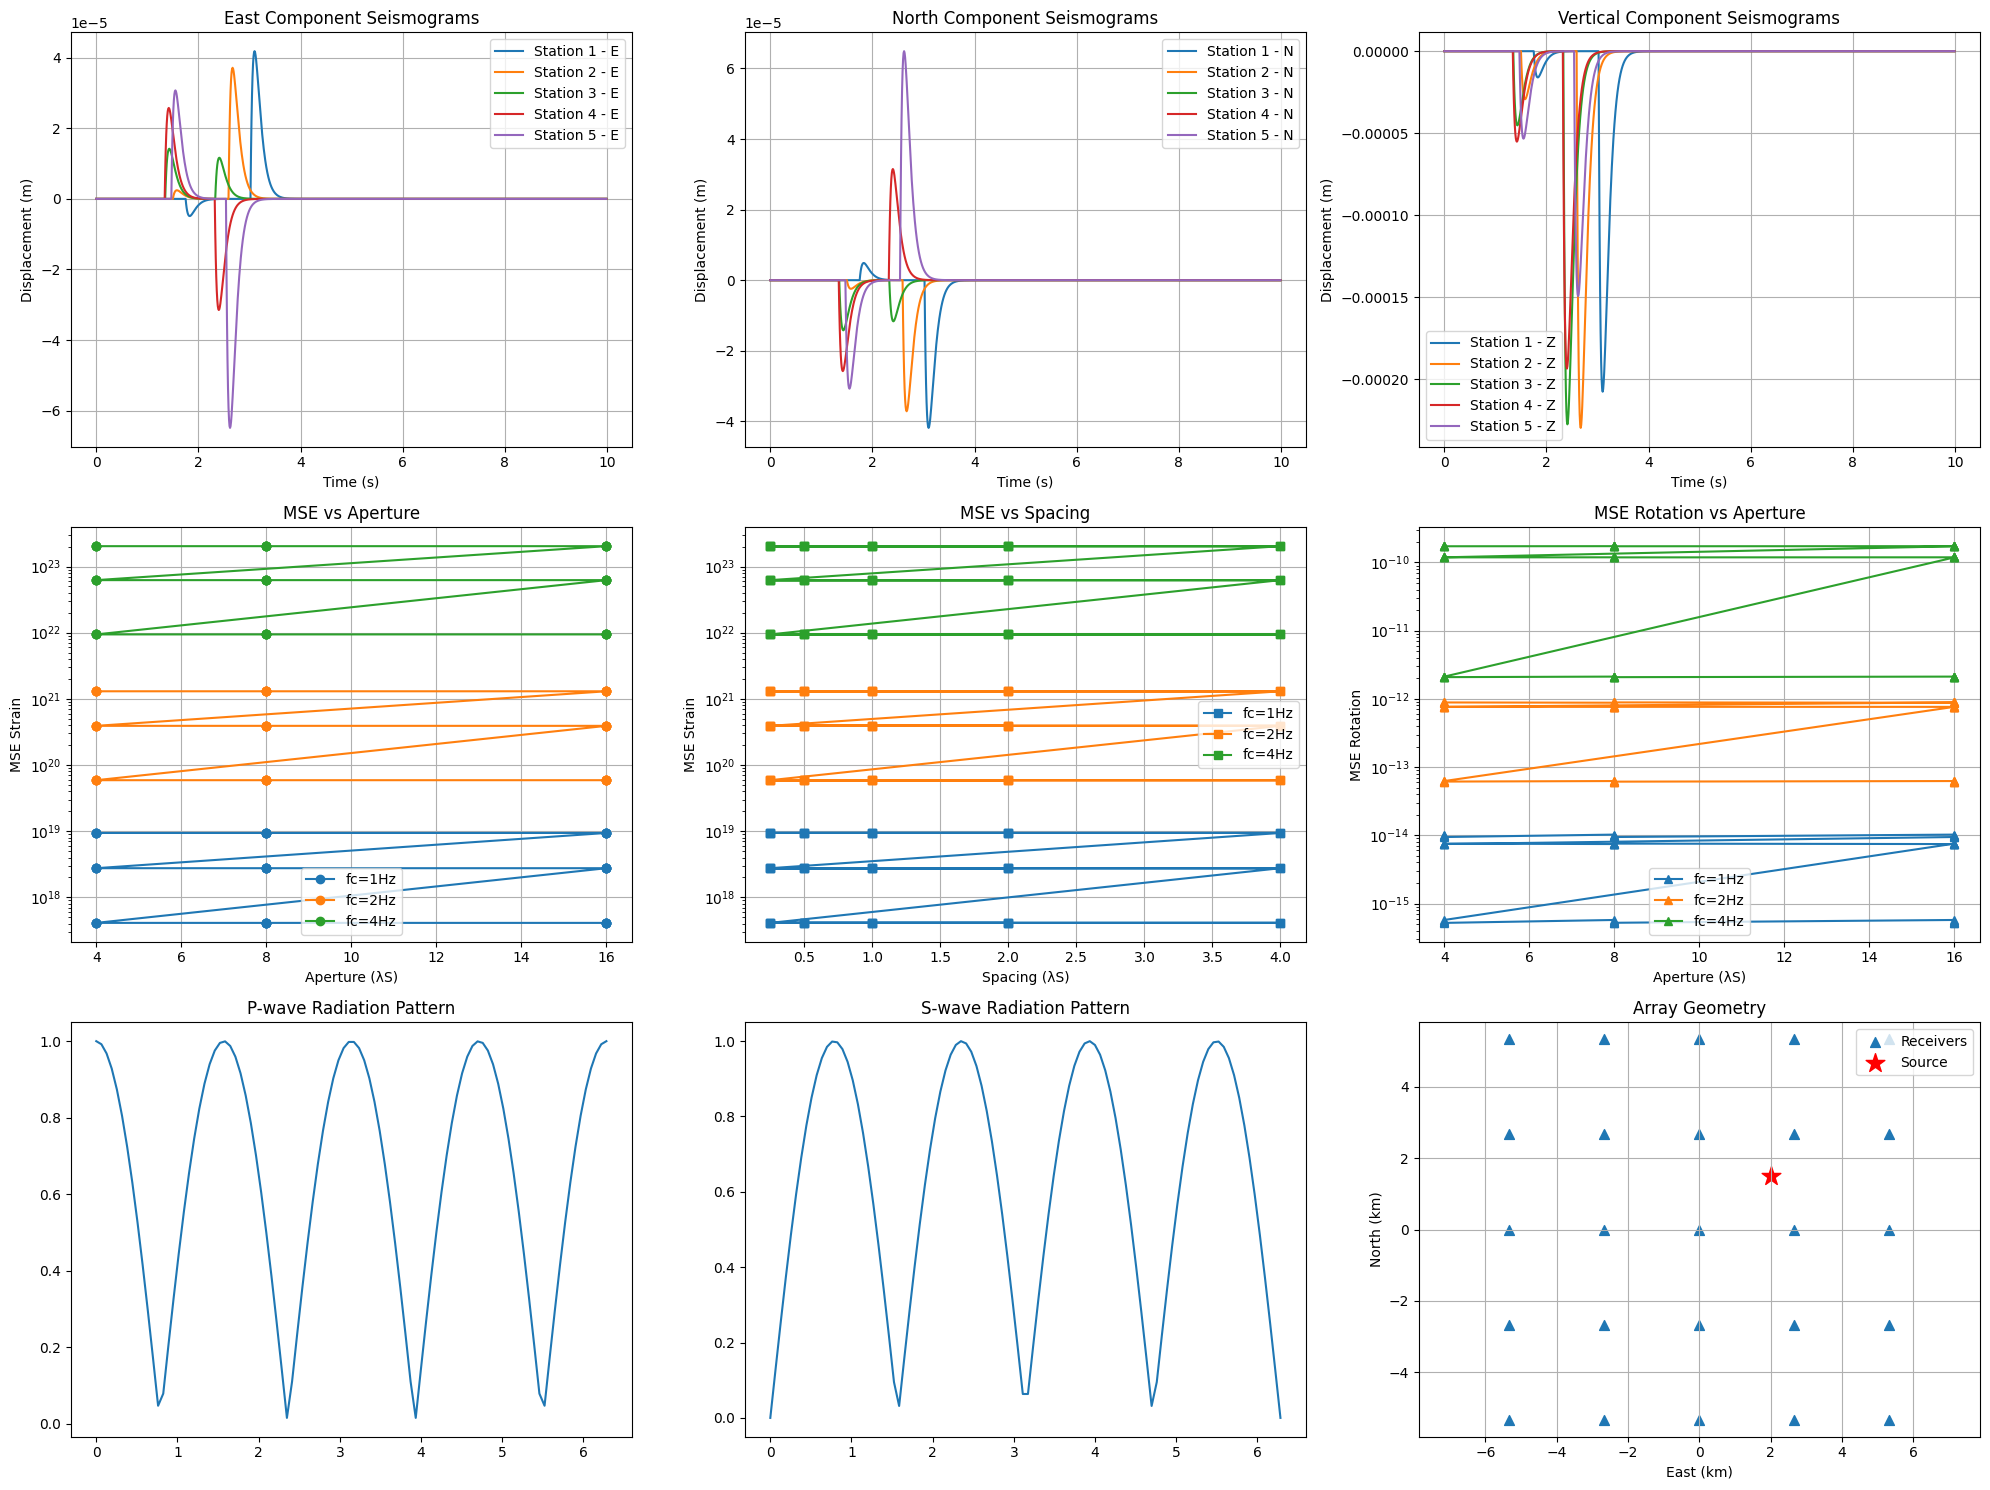

In [40]:
# Run the analysis on the config information defined in .json file, called earlier
analysis_results = analysis(config)

- Synthetic seismogram components show a wide range of responses since, in this example, the earthquake source is below the array.
- The aperture and spacing are iterated over in the MSE plots, and clearly a range of values are present for both strain MSE and rotation MSE across spacings and apertures
- Radiation patterns are given with respect to theta
- Depth z_s = 3 km, and horizontal position is arbitrary in the array geometry

In [47]:
# Look at analysis_results,
# print out which parameters of aperture and spacing minimize MSE for strain and rotation
# Show for two values of f_c

print("  Analyzing Optimal Array Parameters for MSE Minimization")
print("=" * 60)

# Check if we have analysis results
if 'mse_strain' not in analysis_results or len(analysis_results['mse_strain']) == 0:
    print(" No MSE results found. Analysis may not have run properly.")
else:
    # Convert results to DataFrame for easier analysis
    params_df = pd.DataFrame(analysis_results['parameters'])
    params_df['mse_strain'] = analysis_results['mse_strain']
    params_df['mse_rotation'] = analysis_results['mse_rotation']
    
    # Add normalized parameters
    params_df['aperture_norm'] = params_df['aperture'] / params_df['lambda_s']
    params_df['spacing_norm'] = params_df['spacing'] / params_df['lambda_s']
    
    print(f"  Total parameter combinations analyzed: {len(params_df)}")
    print(f"  Corner frequencies tested: {sorted(params_df['fc'].unique())} Hz")
    print(f"   Source depths tested: {sorted(params_df['zs'].unique())} m")
    
    # Focus on two fc values as requested
    fc_values_to_analyze = [1, 2]  # Lower and medium frequency
    
    for fc_val in fc_values_to_analyze:
        print(f"\n ANALYSIS FOR fc = {fc_val} Hz")
        print("-" * 40)
        
        # Filter data for this fc value
        fc_data = params_df[params_df['fc'] == fc_val].copy()
        
        if fc_data.empty:
            print(f"      No data available for fc = {fc_val} Hz")
            continue
            
        # Find optimal parameters for STRAIN
        min_strain_idx = fc_data['mse_strain'].idxmin()
        optimal_strain = fc_data.loc[min_strain_idx]
        
        print(f"   OPTIMAL STRAIN PARAMETERS:")
        print(f"        Aperture: {optimal_strain['aperture_norm']:.2f}λS ({optimal_strain['aperture']:.0f} m)")
        print(f"        Spacing:  {optimal_strain['spacing_norm']:.2f}λS ({optimal_strain['spacing']:.0f} m)")
        print(f"        MSE:      {optimal_strain['mse_strain']:.2e}")
        
        # Find optimal parameters for ROTATION
        min_rotation_idx = fc_data['mse_rotation'].idxmin()
        optimal_rotation = fc_data.loc[min_rotation_idx]
        
        print(f"   OPTIMAL ROTATION PARAMETERS:")
        print(f"        Aperture: {optimal_rotation['aperture_norm']:.2f}λS ({optimal_rotation['aperture']:.0f} m)")
        print(f"        Spacing:  {optimal_rotation['spacing_norm']:.2f}λS ({optimal_rotation['spacing']:.0f} m)")
        print(f"        MSE:      {optimal_rotation['mse_rotation']:.2e}")
        
        # Summary statistics for this fc
        print(f"    RANGE ANALYSIS:")
        print(f"      Strain MSE range:   {fc_data['mse_strain'].min():.2e} - {fc_data['mse_strain'].max():.2e}")
        print(f"      Rotation MSE range: {fc_data['mse_rotation'].min():.2e} - {fc_data['mse_rotation'].max():.2e}")
        print(f"      Aperture range:     {fc_data['aperture_norm'].min():.1f} - {fc_data['aperture_norm'].max():.1f}λS")
        print(f"      Spacing range:      {fc_data['spacing_norm'].min():.1f} - {fc_data['spacing_norm'].max():.1f}λS")
    
    # Cross-frequency comparison
    print(f"\n CROSS-FREQUENCY COMPARISON")
    print("-" * 40)
    
    # Best overall configurations
    overall_best_strain = params_df.loc[params_df['mse_strain'].idxmin()]
    overall_best_rotation = params_df.loc[params_df['mse_rotation'].idxmin()]
    
    print(f" BEST OVERALL STRAIN CONFIGURATION:")
    print(f"   fc = {overall_best_strain['fc']} Hz, depth = {overall_best_strain['zs']:.0f} m")
    print(f"   Aperture = {overall_best_strain['aperture_norm']:.2f}λS, Spacing = {overall_best_strain['spacing_norm']:.2f}λS")
    print(f"   MSE = {overall_best_strain['mse_strain']:.2e}")
    
    print(f" BEST OVERALL ROTATION CONFIGURATION:")
    print(f"   fc = {overall_best_rotation['fc']} Hz, depth = {overall_best_rotation['zs']:.0f} m")
    print(f"   Aperture = {overall_best_rotation['aperture_norm']:.2f}λS, Spacing = {overall_best_rotation['spacing_norm']:.2f}λS")
    print(f"   MSE = {overall_best_rotation['mse_rotation']:.2e}")
    
    # Trends analysis
    print(f"\n  GENERAL TRENDS:")
    
    # Aperture effects
    aperture_corr_strain = params_df['aperture_norm'].corr(params_df['mse_strain'])
    aperture_corr_rotation = params_df['aperture_norm'].corr(params_df['mse_rotation'])
    
    print(f"     Aperture correlation with MSE:")
    print(f"      Strain:   {aperture_corr_strain:+.3f} {'(larger aperture → lower MSE)' if aperture_corr_strain < -0.1 else '(larger aperture → higher MSE)' if aperture_corr_strain > 0.1 else '(weak correlation)'}")
    print(f"      Rotation: {aperture_corr_rotation:+.3f} {'(larger aperture → lower MSE)' if aperture_corr_rotation < -0.1 else '(larger aperture → higher MSE)' if aperture_corr_rotation > 0.1 else '(weak correlation)'}")
    
    # Spacing effects  
    spacing_corr_strain = params_df['spacing_norm'].corr(params_df['mse_strain'])
    spacing_corr_rotation = params_df['spacing_norm'].corr(params_df['mse_rotation'])
    
    print(f"     Spacing correlation with MSE:")
    print(f"      Strain:   {spacing_corr_strain:+.3f} {'(denser spacing → lower MSE)' if spacing_corr_strain > 0.1 else '(denser spacing → higher MSE)' if spacing_corr_strain < -0.1 else '(weak correlation)'}")
    print(f"      Rotation: {spacing_corr_rotation:+.3f} {'(denser spacing → lower MSE)' if spacing_corr_rotation > 0.1 else '(denser spacing → higher MSE)' if spacing_corr_rotation < -0.1 else '(weak correlation)'}")

print(f"\n  Optimal parameter analysis complete!")
print("   Check the plots above for visual MSE curves vs aperture and spacing.")


  Analyzing Optimal Array Parameters for MSE Minimization
  Total parameter combinations analyzed: 126
  Corner frequencies tested: [np.int64(1), np.int64(2), np.int64(4)] Hz
   Source depths tested: [np.int64(1000), np.int64(3000), np.int64(5000)] m

 ANALYSIS FOR fc = 1 Hz
----------------------------------------
   OPTIMAL STRAIN PARAMETERS:
        Aperture: 4.00λS (10658 m)
        Spacing:  0.25λS (666 m)
        MSE:      4.12e+17
   OPTIMAL ROTATION PARAMETERS:
        Aperture: 4.00λS (10658 m)
        Spacing:  2.00λS (5329 m)
        MSE:      5.20e-16
    RANGE ANALYSIS:
      Strain MSE range:   4.12e+17 - 9.41e+18
      Rotation MSE range: 5.20e-16 - 1.02e-14
      Aperture range:     4.0 - 16.0λS
      Spacing range:      0.2 - 4.0λS

 ANALYSIS FOR fc = 2 Hz
----------------------------------------
   OPTIMAL STRAIN PARAMETERS:
        Aperture: 4.00λS (5329 m)
        Spacing:  0.25λS (333 m)
        MSE:      5.90e+19
   OPTIMAL ROTATION PARAMETERS:
        Aperture: 8

- For f_c = 1.0 Hz, optimal aperture is 4.0λ_s, though optimal spacing for minimizing MSE changes depending on whether strain or rotation error is minimized
- For f_c = 2.0 Hz, optimal aperture is 4.0-8.0λ_s, and we see the same sensitivity to MSE depending on strain or rotation
- This could be an effect of the earthquake location right below
- See the one-page report for more detail